Statistical Analysis on E-Commerce Reviews, with Sentiment Classification using Bidirectional Recurrent Neural Network (RNN)
===

This report is based on Nick Brooks' [report](https://www.kaggle.com/nicapotato/guided-numeric-and-text-exploration-e-commerce/notebook) on the same subject.

## Abstract
Understanding customer sentiments is of paramount importance in marketing strategies today. Not only will it give companies an insight as to how customers perceive their products and/or services, but it will also give them an idea on how to improve their offers. This paper attempts to understand the correlation of different variables in customer reviews on a women clothing e-commerce, and to classify each review whether it recommends the reviewed product or not and whether it consists of positive, negative, or neutral sentiment. To achieve these goals, we employed univariate and multivariate analyses on dataset features except for review titles and review texts, and we implemented a bidirectional recurrent neural network (RNN) with long-short term memory unit (LSTM) for recommendation and sentiment classification. Results have shown that a recommendation is a strong indicator of a positive sentiment score, and vice-versa. On the other hand, ratings in product reviews are fuzzy indicators of sentiment scores. We also found out that the bidirectional LSTM was able to reach an F1-score of 0.88 for recommendation classification, and 0.93 for sentiment classification.

In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [3]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [4]:
for column in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[column].notnull()]
df.drop(df.columns[0], inplace=True, axis=1)

In [5]:
df.shape

(22628, 10)

In [6]:
df['Label'] = 0

In [7]:
df.loc[df.Rating >= 3, ['Label']] = 1

In [8]:
df['Word Count'] = df['Review Text'].str.split().apply(len)

In [9]:
df.sample(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Label,Word Count
4975,927,40,Better in person than the photos,"Like another reviewer, i was in the store look...",4,1,1,General,Tops,Sweaters,1,97
19423,873,41,Great top!,I wore this for the first time this weekend an...,5,1,1,General,Tops,Knits,1,54
2776,868,42,Love it!!,I tried this (black motif) on yesterday in my ...,5,1,3,General,Tops,Knits,1,94
20774,1110,68,You will feel so elegant!,"As part of the over 60 crowd, i rarely wear dr...",5,1,0,General,Dresses,Dresses,1,75
1177,1094,53,Beautiful summer dress,I was unsure about this dress when i first tri...,4,1,0,General Petite,Dresses,Dresses,1,82


In [10]:
df.describe().T.drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
Clothing ID,919.695908,201.683804,1.0,861.0,936.0,1078.0,1205.0
Age,43.282880,12.328176,18.0,34.0,41.0,52.0,99.0
Rating,4.183092,1.115911,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.818764,0.385222,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.631784,5.787520,0.0,0.0,1.0,3.0,122.0
Label,0.895263,0.306222,0.0,1.0,1.0,1.0,1.0
Word Count,60.211950,28.533053,2.0,36.0,59.0,88.0,115.0


In [11]:
df[['Title', 'Division Name', 'Department Name', 'Class Name']].describe(include=['O']).T.drop('count', axis=1)

,unique,top,freq
Title,13983,Love it!,136
Division Name,3,General,13365
Department Name,6,Tops,10048
Class Name,20,Dresses,6145


# Univariate Distributions

## Age and Positive Feedback Frequency Distributions

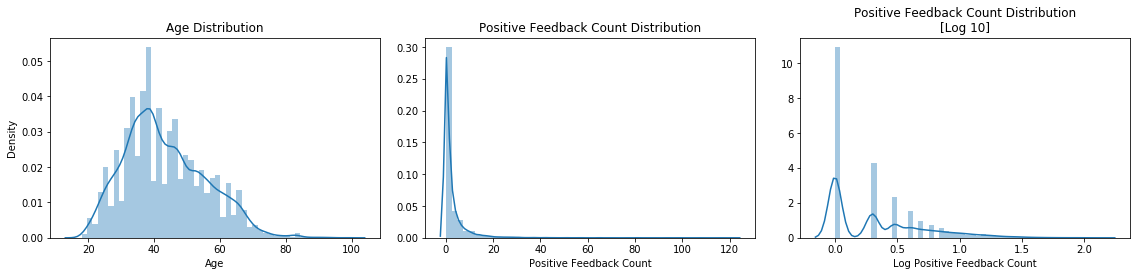

In [11]:
f, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=False)
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title('Age Distribution')
ax[0].set_ylabel('Density')
sns.distplot(df['Positive Feedback Count'], ax=ax[1])
ax[1].set_title('Positive Feedback Count Distribution')
sns.distplot(np.log10((df['Positive Feedback Count'][df['Positive Feedback Count'].notnull()] + 1)), ax=ax[2])
ax[2].set_title('Positive Feedback Count Distribution\n[Log 10]')
ax[2].set_xlabel('Log Positive Feedback Count')
plt.rcParams.update({'font.size': 12})
plt.tight_layout()
plt.savefig('age-and-positive-feedback-freqdist.png', format='png', dpi=600)
plt.show()

## Division Name and Department Name Distributions

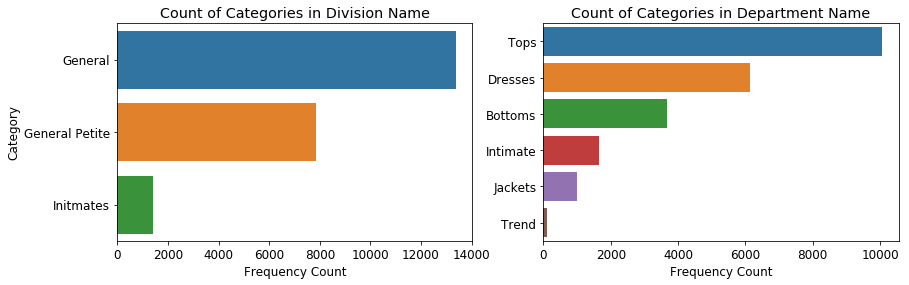

In [12]:
row_plots = ['Division Name', 'Department Name']
f, axes = plt.subplots(1, len(row_plots), figsize=(14, 4), sharex=False)

for i, x in enumerate(row_plots):
    sns.countplot(y=x, data=df, order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title('Count of Categories in {}'.format(x))
    axes[i].set_xlabel('')
    axes[i].set_xlabel('Frequency Count')
axes[0].set_ylabel('Category')
axes[1].set_ylabel('')
plt.savefig('divname-and-deptname-freqdist.png', format='png', dpi=600)
plt.show()

## Clothing ID Frequency Distribution

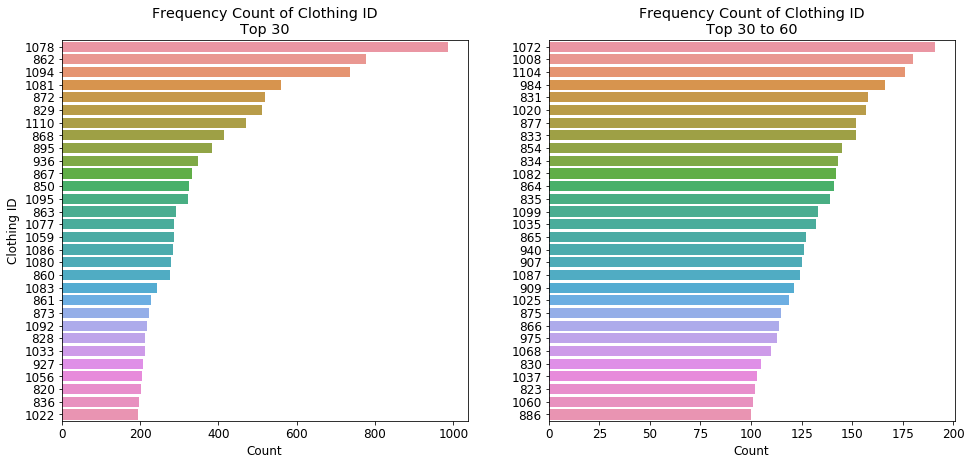

Dataframe Dimension: 22628 Rows


,mean,std,min,25%,50%,75%,max
Clothing ID,1015.4848,103.396022,862.0,862.0,1078.0,1094.0,1094.0
Age,42.7248,12.150429,18.0,34.0,41.0,51.0,99.0
Rating,4.1892,1.104306,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.8184,0.385592,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.8624,6.773021,0.0,0.0,1.0,3.0,98.0
Label,0.9024,0.296832,0.0,1.0,1.0,1.0,1.0
Word Count,60.5912,28.731486,2.0,36.0,60.0,89.0,115.0


In [13]:
# Clothing ID Category
f, axes = plt.subplots(1, 2, figsize=[16, 7])
num = 30
sns.countplot(y='Clothing ID', data=df[df['Clothing ID'].isin(df['Clothing ID'].value_counts()[:num].index)],
              order= df['Clothing ID'].value_counts()[:num].index, ax=axes[0])
axes[0].set_title('Frequency Count of Clothing ID\nTop 30')
axes[0].set_xlabel('Count')

sns.countplot(y='Clothing ID', data=df[df['Clothing ID'].isin(df['Clothing ID'].value_counts()[num:60].index)],
              order=df['Clothing ID'].value_counts()[num:60].index, ax=axes[1])
axes[1].set_title('Frequency Count of Clothing ID\nTop 30 to 60')
axes[1].set_ylabel('')
axes[1].set_xlabel('Count')
plt.savefig('freqdist-clothingid-top60.png', format='png', dpi=600)
plt.show()

print('Dataframe Dimension: {} Rows'.format(df.shape[0]))
df[df['Clothing ID'].isin([1078, 862,1094])].describe().T.drop('count',axis=1)

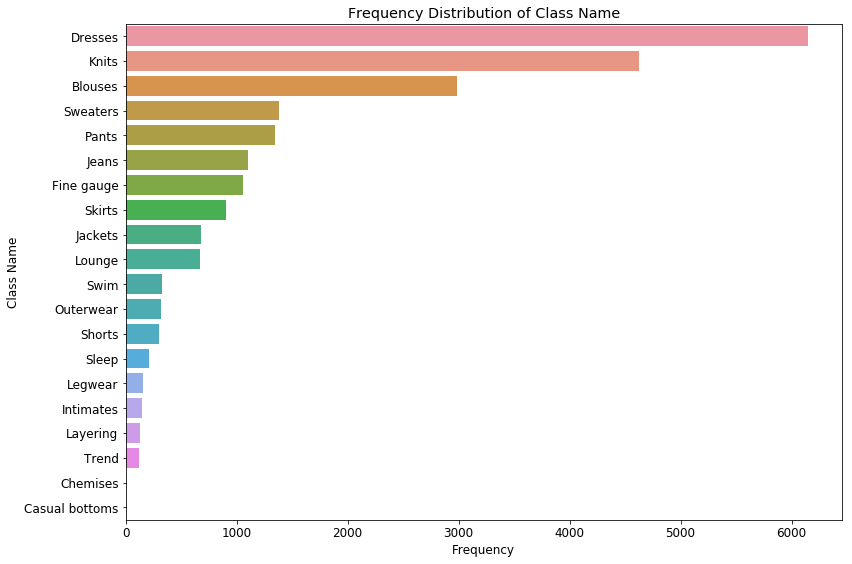

In [14]:
# Class Name
plt.subplots(figsize=(12, 8))
sns.countplot(y='Class Name', data=df,order=df['Class Name'].value_counts().index)
plt.title('Frequency Distribution of Class Name')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig('freqdist-classname.png', format='png', dpi=300)
plt.show()

## Frequency Distribution of Rating, Recommended IND, and Label

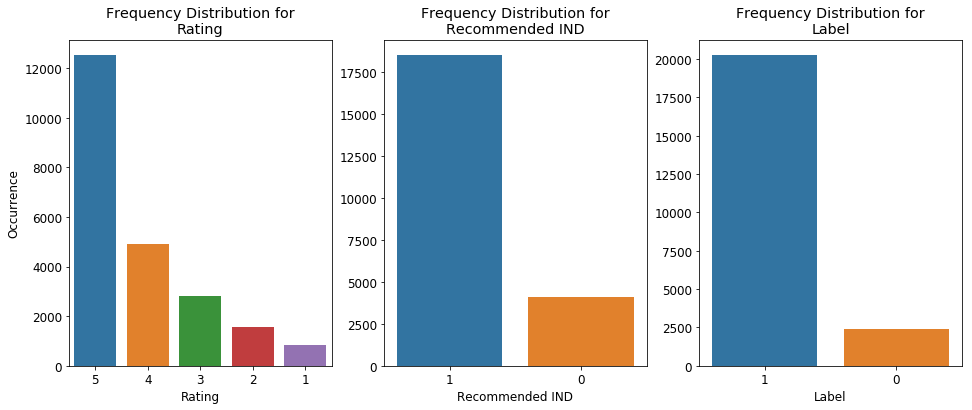

In [15]:
cat_dtypes = ['Rating', 'Recommended IND', 'Label']
increment = 0
f, axes = plt.subplots(1, len(cat_dtypes), figsize=(16, 6), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment], data=df, order=df[cat_dtypes[increment]].value_counts().index, ax=axes[i])
    axes[i].set_title('Frequency Distribution for\n{}'.format(cat_dtypes[increment]))
    axes[i].set_ylabel('Occurrence')
    axes[i].set_xlabel('{}'.format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel('')
axes[2].set_ylabel('')
plt.savefig('freqdist-rating-recommended-label.png', format='png', dpi=300)
plt.show()

## Word Count by Rating, Department Name, and Recommended IND

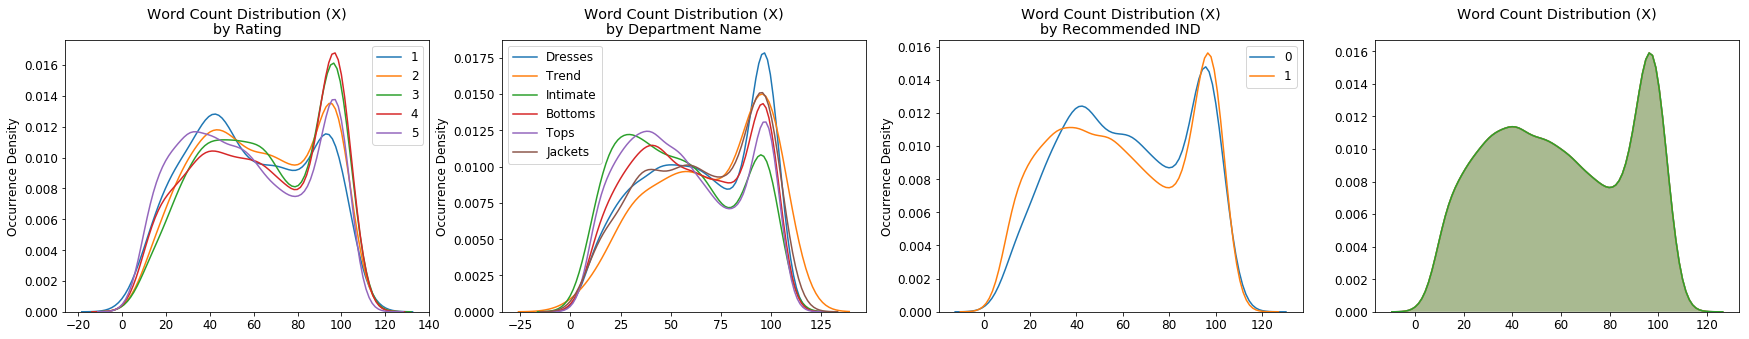


Total Word Count is: 1362476


count    22628.000000
mean        60.211950
std         28.533053
min          2.000000
25%         36.000000
50%         59.000000
75%         88.000000
max        115.000000
Name: Word Count, dtype: float64

In [16]:
f, axes = plt.subplots(1, 4, figsize=(30, 5), sharex=False)

for index, y in enumerate(['Rating', 'Department Name', 'Recommended IND']):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(df['Word Count'][df[y]==x], label=x, shade=False, ax=axes[index])
        axes[index].set_title('{} Distribution (X)\nby {}'.format('Word Count', y))
    axes[index].set_ylabel('Occurrence Density')
    axes[index].set_xlabel('')
    
    # Plot 4
    axes[3].set_title('Word Count Distribution (X)\n')
    sns.kdeplot(df['Word Count'],shade=True,ax=axes[3])
    axes[index].set_xlabel("")
    axes[3].legend_.remove()
plt.savefig('wordcountdist-rating-deptname-recommended.png', format='png', dpi=300)
plt.show()

print("\nTotal Word Count is: {}".format(df["Word Count"].sum()))
df['Word Count'].describe().T

# Multivariate Distributions

## Categorical Variable by Categorical Variable

## Division Name by Department Name

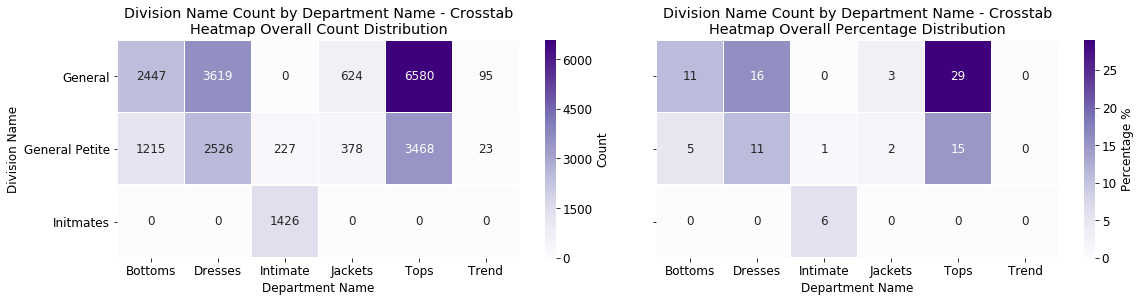

In [17]:
f, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name']),
            annot=True, linewidths=.5, ax=ax[0], fmt='g', cmap='Purples',
            cbar_kws={'label': 'Count'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name'], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap='Purples',
            cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('divname-deptname.png', format='png', dpi=300)
plt.show()

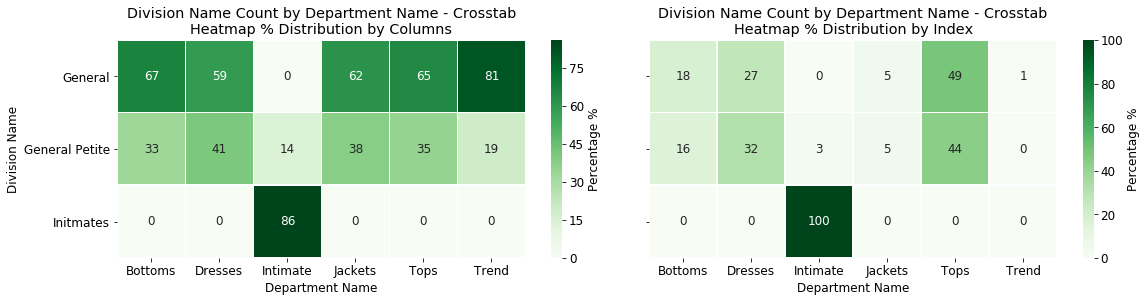

In [18]:
f, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name'], normalize='columns').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[0], fmt='g', cmap='Greens',
            cbar_kws={'label': 'Percentage %'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Columns')

sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name'], normalize='index').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap='Greens',
            cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Index')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('divname-deptname-pivot.png', format='png', dpi=300)
plt.show()

## Class Name by Department Name

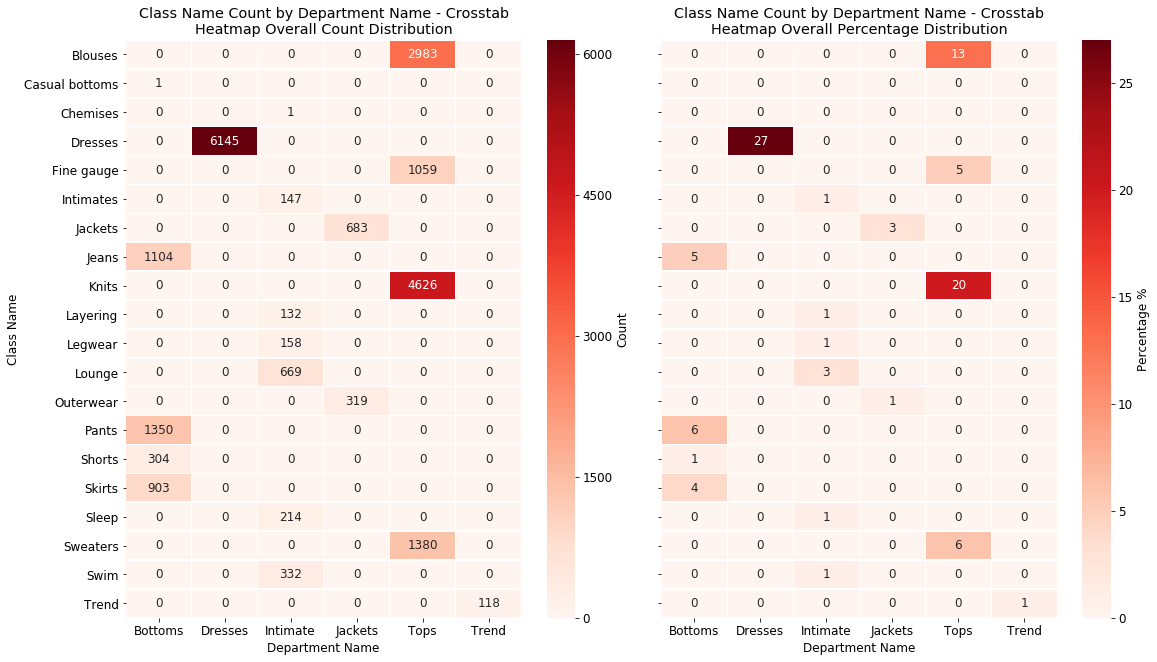

In [19]:
f, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df['Department Name']),
            annot=True, linewidths=.5, ax=ax[0], fmt='g', cmap='Reds',
            cbar_kws={'label': 'Count'})
ax[0].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Class Name'], df['Department Name'], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap='Reds',
            cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('classname-deptname.png', format='png', dpi=300)
plt.show()

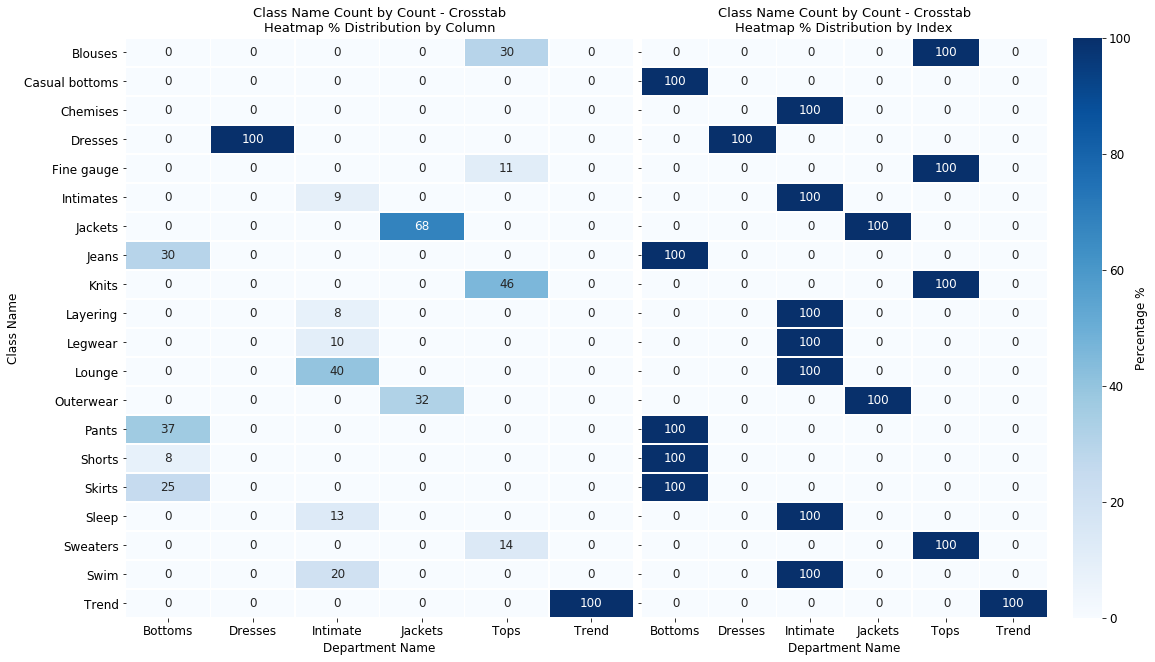

In [20]:
f, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df['Department Name'], normalize = 'columns').mul(100).round(0),
            annot=True, fmt='g', linewidths=.5, ax=ax[0],cbar=False, cmap='Blues')
ax[0].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Column', fontsize=fsize)
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df['Department Name'], normalize = 'index').mul(100).round(0),
                    annot=True, fmt='2g', linewidths=.5, ax=ax[1],cmap='Blues',
                    cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Index', fontsize=fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('classname-deptname-pivot.png', format='png', dpi=300)
plt.show()

## Division Name by Department Name

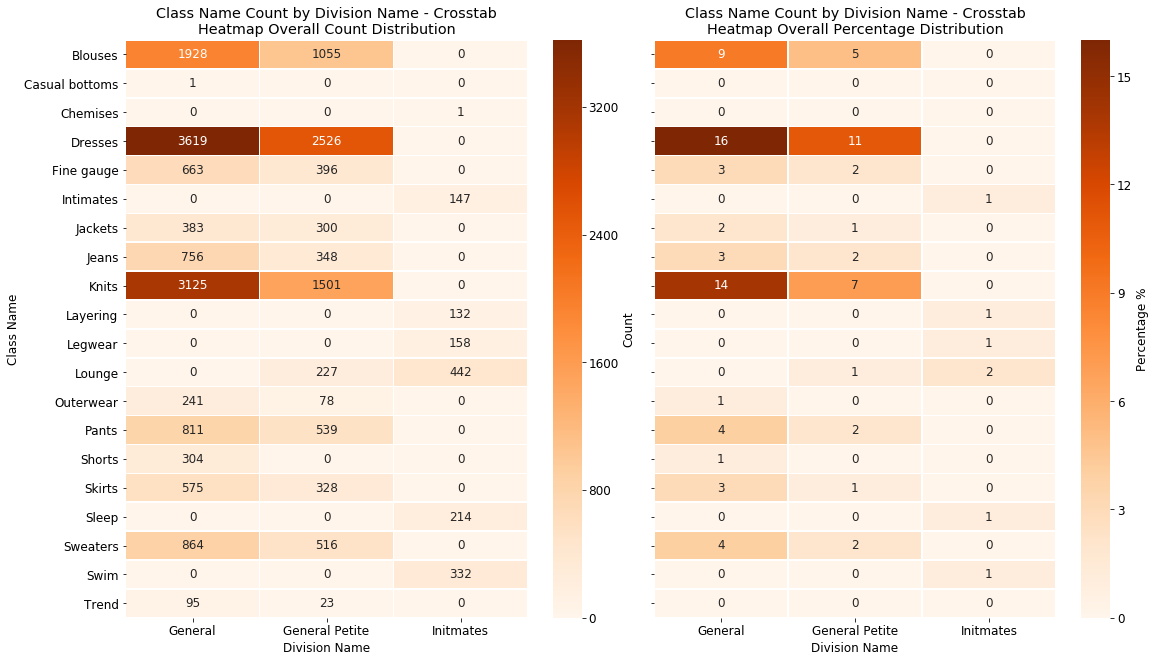

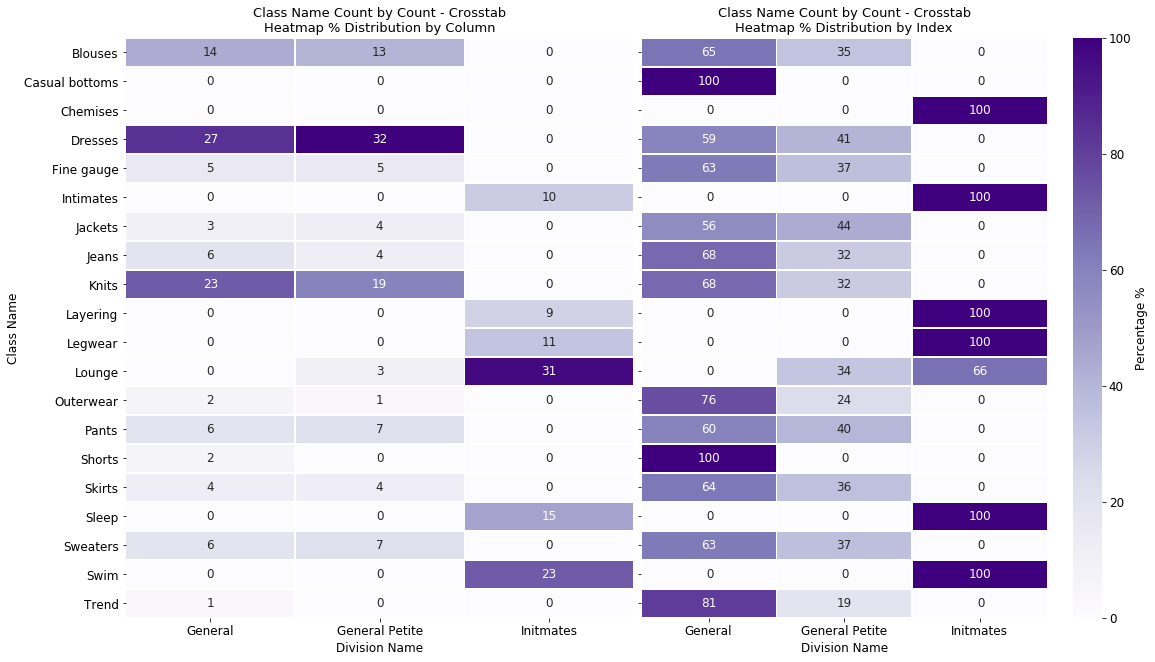

In [21]:
f, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df['Division Name']),
            annot=True, linewidths=.5, ax=ax[0], fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Count'})
ax[0].set_title('Class Name Count by Division Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Class Name'], df['Division Name'], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1], fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Division Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('classname-divname.png', format='png', dpi=300)
plt.show()

# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df['Division Name'], normalize = 'columns').mul(100).round(0),
            annot=True, fmt='g', linewidths=.5, ax=ax[0],cbar=False,cmap='Purples')
ax[0].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Column', fontsize = fsize)
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df['Division Name'], normalize = 'index').mul(100).round(0),
                    annot=True, fmt='2g', linewidths=.5, ax=ax[1], cmap='Purples',
                    cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Index', fontsize=fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('classname-divname-pivot.png', format='png', dpi=300)

## Continuous Variable by Continuous Variable

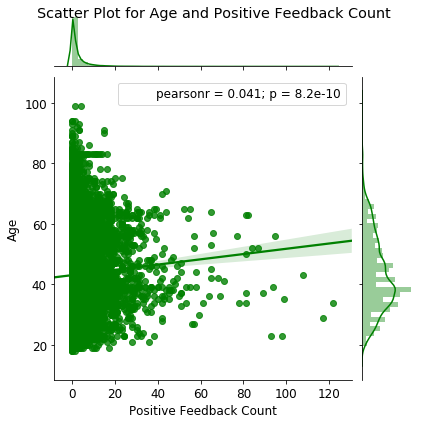

In [22]:
def minmaxscaler(df):
    return (df - df.min()) / (df.max() - df.min())

def zscorenomalize(df):
    return (df - df.mean()) / df.std()

g = sns.jointplot(x=df['Positive Feedback Count'], y=df['Age'], kind='reg', color='g')
g.fig.suptitle("Scatter Plot for Age and Positive Feedback Count")
plt.savefig('positivefeedback-age.png', format='png', dpi=300)
plt.show()

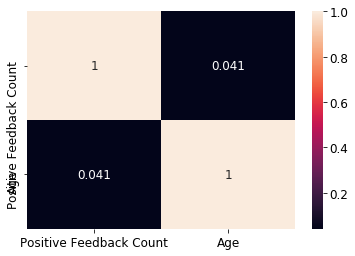

In [23]:
sns.heatmap(df[['Positive Feedback Count', 'Age']].corr(), annot=True)

## Percentage Standardize Distribution Plots

In [24]:
def percentstandardize_barplot(x, y, hue, data, ax=None, order=None):
    """
    Standardize by percentage the data using pandas functions, then plot using Seaborn.
    Function arguments are and extention of Seaborns'.
    """
    sns.barplot(x=x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
          .reset_index(drop=True)
          .groupby([x])[hue]
          .value_counts(normalize=True)
          .rename('Percentage').mul(100)
          .reset_index()
          .sort_values(hue)))
    plt.title('Percentage Frequency of {} by {}'.format(hue, x))
    plt.ylabel('Percentage %')

## Recommended IND by Department and Division

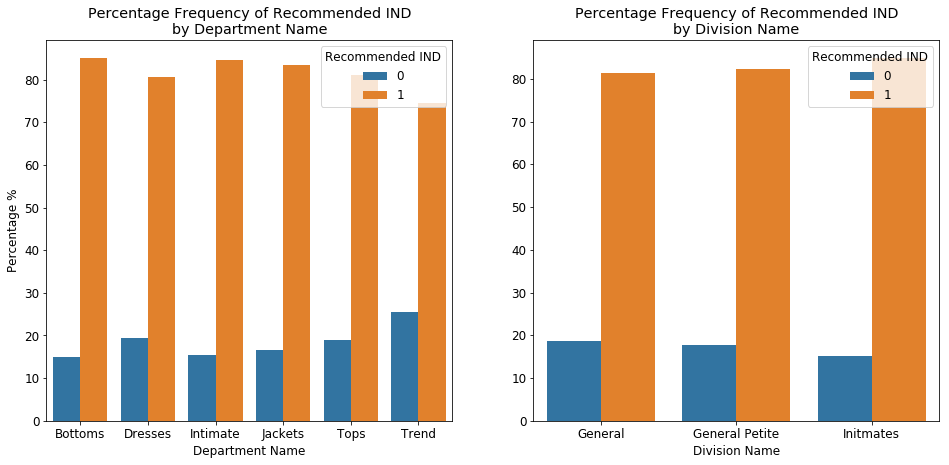

In [25]:
huevar = 'Recommended IND'
f, axes = plt.subplots(1, 2, figsize=(16, 7))
percentstandardize_barplot(x='Department Name', y='Percentage', hue=huevar,data=df, ax=axes[0])
axes[0].set_title('Percentage Frequency of {}\nby Department Name'.format(huevar))
axes[0].set_ylabel('Percentage %')
percentstandardize_barplot(x='Division Name', y='Percentage', hue=huevar, data=df, ax=axes[1])
axes[1].set_title('Percentage Frequency of {}\nby Division Name'.format(huevar))
axes[1].set_ylabel('')
plt.savefig('recommended-deptname-divname.png', format='png', dpi=300)
plt.show()

## Rating by Department and Division Name

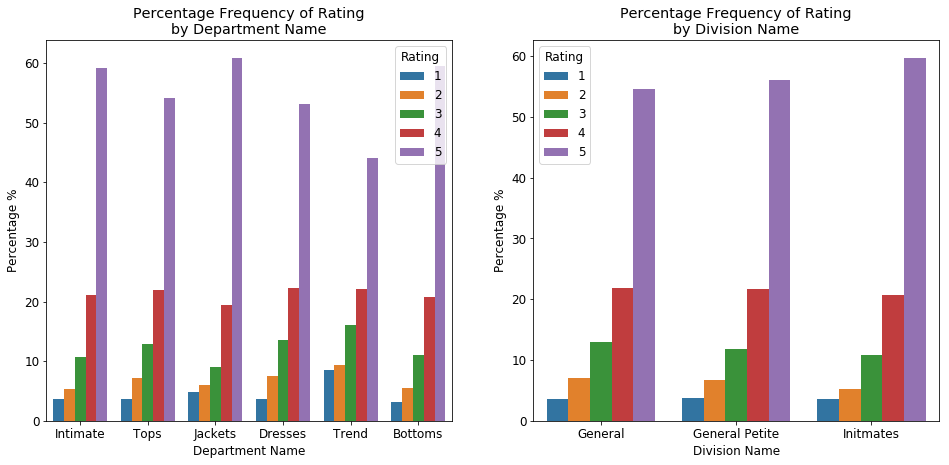

In [26]:
xvar = ['Department Name', 'Division Name']
huevar = 'Rating'
f, axes = plt.subplots(1, 2, figsize=(16, 7))
percentstandardize_barplot(x=xvar[0], y='Percentage', hue=huevar, data=df, ax=axes[0])
axes[0].set_title('Percentage Frequency of {}\nby {}'.format(huevar, xvar[0]))
axes[0].set_ylabel('Percentage %')
percentstandardize_barplot(x=xvar[1], y='Percentage', hue=huevar, data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby {}".format(huevar, xvar[1]))
plt.savefig('rating-deptname-divname.png', format='png', dpi=300)
plt.show()

## Rating by Recommended IND

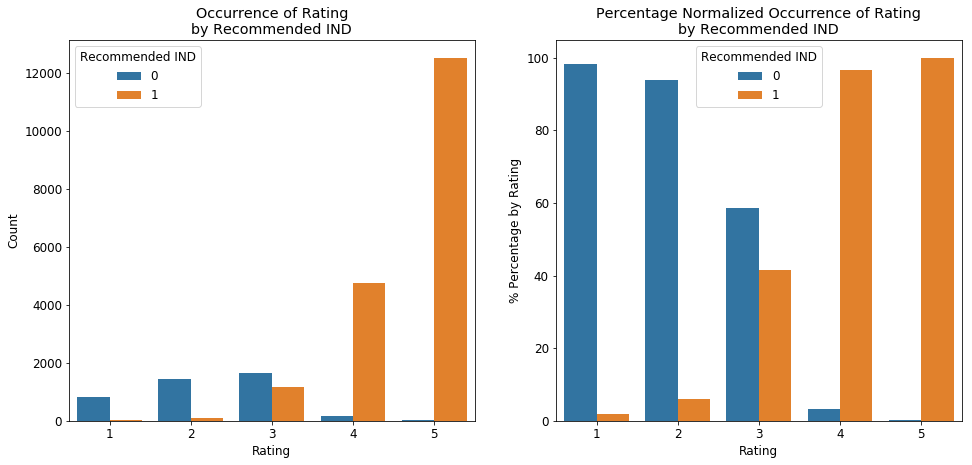

In [27]:
huevar = 'Rating'
f, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.countplot(x='Rating', hue='Recommended IND', data=df, ax=axes[0])
axes[0].set_title('Occurrence of {}\nby {}'.format(huevar, 'Recommended IND'))
axes[0].set_ylabel('Count')
percentstandardize_barplot(x='Rating', y='Percentage', hue='Recommended IND', data=df, ax=axes[1])
axes[1].set_title('Percentage Normalized Occurrence of {}\nby {}'.format(huevar, 'Recommended IND'))
axes[1].set_ylabel('% Percentage by Rating')
plt.savefig('rating-recommended.png', format='png', dpi=300)
plt.show()

# Multivariate Analysis and Descriptive Statistics

## Rating by Recommended IND

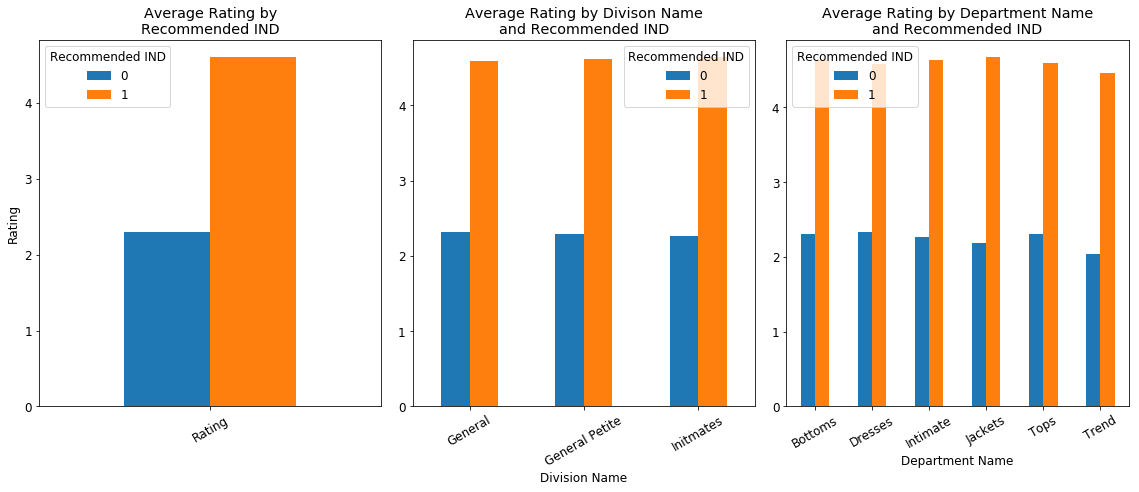

In [28]:
f, axes = plt.subplots(1, 3, figsize=(16, 7))
rot = 30
df.pivot_table('Rating',
               columns=['Recommended IND']).plot.bar(ax=axes[0], rot=rot)
axes[0].set_title('Average Rating by\nRecommended IND')
df.pivot_table('Rating', index='Division Name',
               columns=['Recommended IND']).plot.bar(ax=axes[1], rot=rot)
axes[1].set_title('Average Rating by Divison Name\nand Recommended IND')
df.pivot_table('Rating', index='Department Name',
               columns=['Recommended IND']).plot.bar(ax=axes[2], rot=rot)
axes[0].set_ylabel('Rating')
axes[2].set_title('Average Rating by Department Name\nand Recommended IND')
f.tight_layout()
plt.savefig('meanrating-deptname-recommended.png', format='png', dpi=300)
plt.show()

## Average Rating and Recommended IND by Clothing ID Correlation

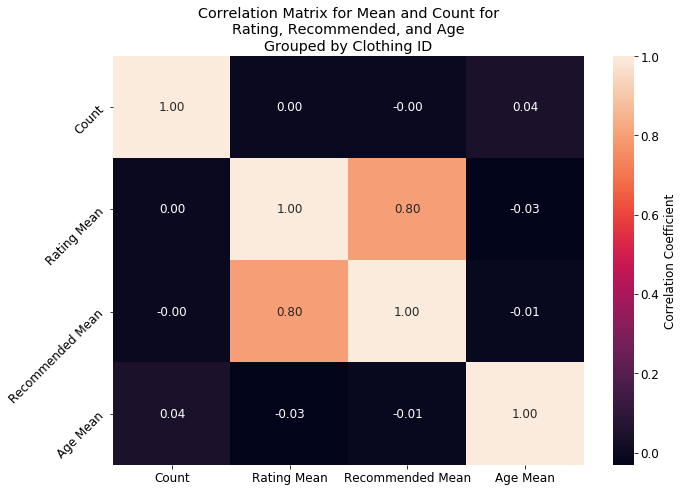

In [29]:
temp = (df.groupby('Clothing ID')[['Rating', 'Recommended IND', 'Age']]
        .aggregate(['count', 'mean']))
temp.columns = ['Count', 'Rating Mean', 'Recommended IND Count',
                'Recommended Mean', 'Age Count', 'Age Mean']
temp.drop(['Recommended IND Count', 'Age Count'], axis=1, inplace=True)

# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[10, 7])
ax = sns.heatmap(temp.corr(),
                 annot=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Correlation Matrix for Mean and Count for\nRating, Recommended, and Age\nGrouped by Clothing ID')
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig('meanrating-recommended-clothing-corr.png', format='png', dpi=300)
plt.show()

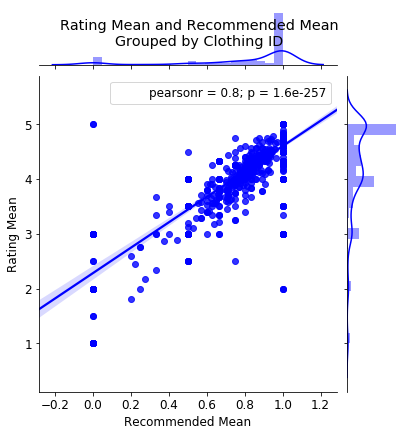

In [30]:
g = sns.jointplot(x='Recommended Mean', y='Rating Mean', data=temp,
                  kind='reg', color='b')
plt.subplots_adjust(top=0.999)
g.fig.suptitle('Rating Mean and Recommended Mean\nGrouped by Clothing ID')
plt.savefig('meanrating-recommended-clothing.png', format='png', dpi=300)
plt.show()

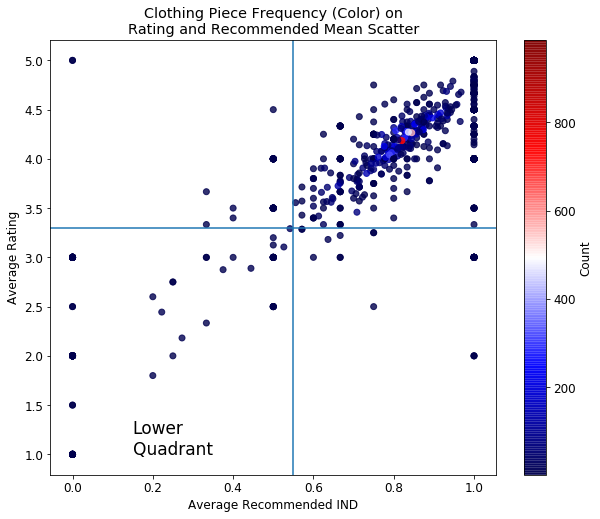

,Count,Rating Mean,Recommended Mean,Age Mean
count,204.000000,204.000000,204.000000,204.000000
mean,2.308824,2.763338,0.316315,41.883954
std,2.798261,0.819220,0.351723,10.858979
min,1.000000,1.000000,0.000000,20.000000
25%,1.000000,2.136364,0.000000,34.687500
50%,1.000000,3.000000,0.250000,41.142857
75%,2.000000,3.000000,0.500000,47.000000
max,24.000000,5.000000,1.000000,74.000000


In [31]:
plt.figure(figsize=(10, 8))
plt.scatter(temp['Recommended Mean'], temp['Rating Mean'],
            alpha=.8, c=temp["Count"], cmap='seismic')
cbar = plt.colorbar() # Color bar. Vive la France!
cbar.set_label('Count', rotation=90)
plt.xlabel('Average Recommended IND')
plt.ylabel('Average Rating')
plt.title('Clothing Piece Frequency (Color) on\nRating and Recommended Mean Scatter')

# Vertical and Horizontal Lines
l = plt.axhline(y=3.3)
l = plt.axvline(x=.55)

# Text
plt.text(.15, 1, 'Lower\nQuadrant', ha='left', wrap=True, fontsize=17)
plt.savefig('low-quadrant.png', format='png', dpi=300)
plt.show()

# Descriptives for LOW QUADRANT
temp[(temp['Rating Mean'] < 3.3) | (temp['Recommended Mean'] <= .55)].describe()


## Average Rating and Recommended IND by Class Name Correlation

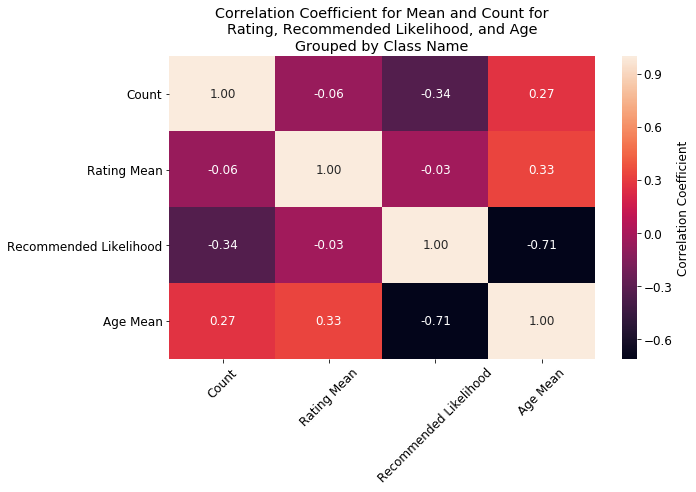

Class Categories:
 ['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' 'Chemises']


In [32]:
key = 'Class Name'
temp = (df.groupby(key)[['Rating', 'Recommended IND', 'Age']]
        .aggregate(['count', 'mean']))
temp.columns = ['Count', 'Rating Mean', 'Recommended Likelihood Count',
                'Recommended Likelihood', 'Age Count', 'Age Mean']
temp.drop(['Recommended Likelihood Count', 'Age Count'], axis=1, inplace=True)

# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[10, 7])
ax = sns.heatmap(temp.corr(),
                 annot=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Correlation Coefficient for Mean and Count for\nRating, Recommended Likelihood, and Age\nGrouped by {}'.format(key))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('meanrating-recommended-classname-corr.png', format='png', dpi=300)
plt.show()
print('Class Categories:\n',df['Class Name'].unique())

(0.7, 1.01)

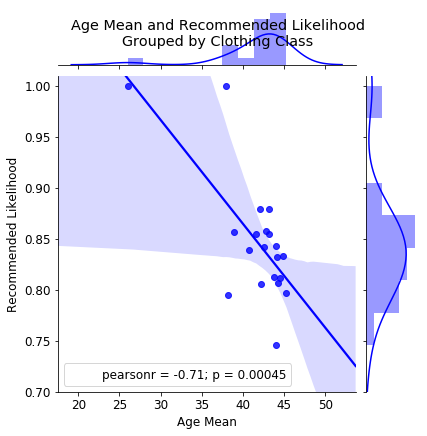

In [33]:
g = sns.jointplot(y='Recommended Likelihood', x='Age Mean', data=temp,
                  kind='reg', color='b')
plt.subplots_adjust(top=0.999)
g.fig.suptitle('Age Mean and Recommended Likelihood\nGrouped by Clothing Class')
plt.savefig('meanage-recommended-clothing.png', format='png', dpi=300)
plt.ylim(.7, 1.01)

# Working with Text

In [34]:
pd.set_option('max_colwidth', 500)
df[["Title","Review Text", "Rating"]].sample(7)

,Title,Review Text,Rating
14497,Polyester,"Love the top design, not so much the fabric. i should've read the top was 100% polyester. returning and finding a better quality top.",3
4897,Beautiful basic for summer,Classic tank with the perfect fit!\r\nsoft aqua perfect for summer.\r\nfit is very true to size!,5
5495,"Pretty, but not for mr","Received this dress, the sleeves are very pretty, the drape was just what i was looking for, but the overall dress was not very flattering on me. i am a little busty on top so it pulled in a unflattering way. i would say that if you are tall and not on the busty side this could be an amazing dress on. this one had to go back",3
18878,Unexpectedly wonderful,"So, i really like the plaid designs by siyu. i saw these pants and questioned whether they would be tight and scratchy and ill fitting, but they were so cute, i had to find out. i'm really glad i did. the wool is soft and actually a little stretchy. it has an elastic waist, which is a plus, because sometimes, even if the legs fit, the waist is too small, or vice versa. i am a large, and very curvy on the bottom, and these are perfect and flattering, and the elastic waist is just right. as on...",5
17636,Cute...on someone else,This top is very cute...on other people. i ordered my normal size (xs) and just did not work out. it's very billowy on the bottom (too much for me) and the top portion did not lay right. the material is thin so you will need to wear a cami underneath it. perhaps if i got the petite xs that right have been a better fit...not sure. in the end the top went back.,4
20218,Easy-fitting dress for casual summer days,"I ordered this dress online and didn't really know what to expect. but to my surprise, it's exactly what i had hoped it would be. the dress is a fantastic fit and has a modern, interesting print. the fabric does seem thin for the price. but i am not returning it. it's a casual summer dress that kicks up my look a notch on weekends. i wear it with beige sandals, and the gray and beige look good together too.",5
16696,Love!,I tried these on in my local store and immediately loved them! they are so flattering on my hourglass shape. the flare leg balances out the hips. great quality and very comfortable. i know i will get so much wear out of these. i bought a size up from my usual size and they fit perfectly.,5


## Text Cleaning

In [35]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words] #4
    return words

## Sentiment Analysis

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Pre-Processing
SIA = SentimentIntensityAnalyzer()
df['Review Text']= df['Review Text'].astype(str)

# Applying Model, Variable Creation
df['Polarity Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['compound'])
df['Neutral Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neu'])
df['Negative Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neg'])
df['Positive Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment'] = ''
df.loc[df['Polarity Score'] > 0, 'Sentiment'] = 'Positive'
df.loc[df['Polarity Score'] == 0, 'Sentiment'] = 'Neutral'
df.loc[df['Polarity Score'] < 0, 'Sentiment'] = 'Negative'

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Normalize Plots for Sentiment Distribution

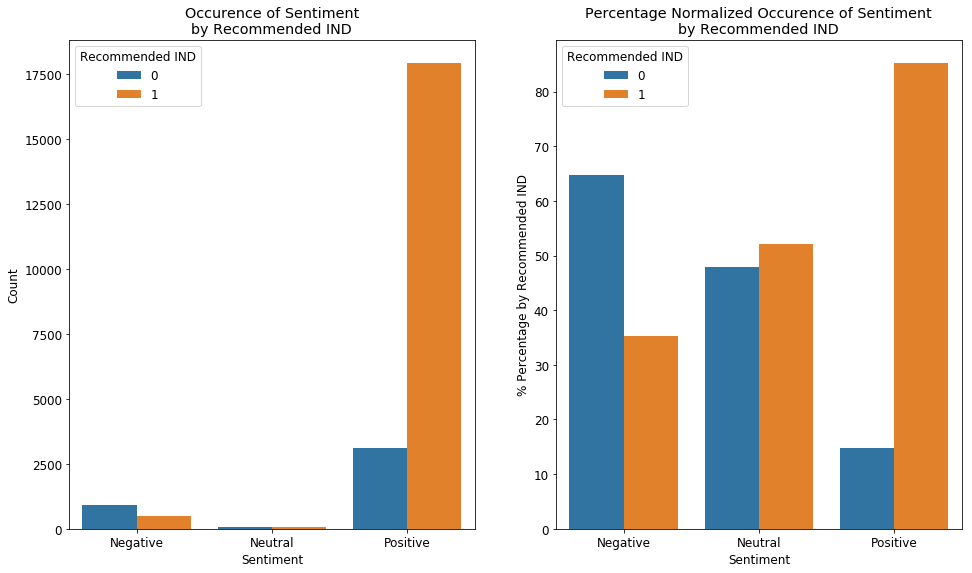

In [37]:
huevar = 'Recommended IND'
xvar = 'Sentiment'
f, axes = plt.subplots(1, 2, figsize=(16, 9))
sns.countplot(x=xvar, hue=huevar,data=df, ax=axes[0], order=['Negative', 'Neutral', 'Positive'])
axes[0].set_title('Occurence of {}\nby {}'.format(xvar, huevar))
axes[0].set_ylabel('Count')
percentstandardize_barplot(x=xvar, y='Percentage', hue=huevar, data=df, ax=axes[1])
axes[1].set_title('Percentage Normalized Occurence of {}\nby {}'.format(xvar, huevar))
axes[1].set_ylabel('% Percentage by {}'.format(huevar))
plt.savefig('norm-sentimentdist.png', format='png', dpi=300)
plt.show()

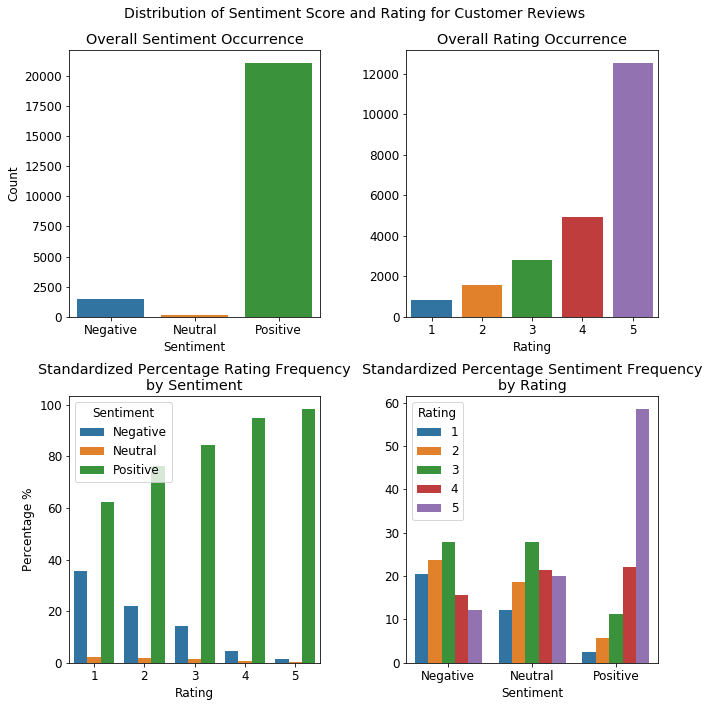

In [38]:
f, axes = plt.subplots(2, 2, figsize=[10, 10])
sns.countplot(x='Sentiment', data=df, ax=axes[0, 0], order=['Negative', 'Neutral', 'Positive'])
axes[0,0].set_xlabel('Sentiment')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Overall Sentiment Occurrence')

sns.countplot(x='Rating', data=df, ax=axes[0, 1])
axes[0,1].set_xlabel('Rating')
axes[0,1].set_ylabel('')
axes[0,1].set_title('Overall Rating Occurrence')

percentstandardize_barplot(x='Rating', y='Percentage', hue='Sentiment', data=df, ax=axes[1, 0])
axes[1,0].set_xlabel('Rating')
axes[1,0].set_ylabel('Percentage %')
axes[1,0].set_title('Standardized Percentage Rating Frequency\nby Sentiment')

percentstandardize_barplot(x='Sentiment', y='Percentage',hue='Rating', data=df, ax=axes[1, 1])
axes[1,1].set_ylabel('Occurrence Frequency')
axes[1,1].set_title('Standardized Percentage Sentiment Frequency\nby Rating')
axes[1,1].set_xlabel('Sentiment')
axes[1,1].set_ylabel('')

f.suptitle('Distribution of Sentiment Score and Rating for Customer Reviews', fontsize=14)
f.tight_layout()
f.subplots_adjust(top=0.92)
plt.savefig('sentimentscoredist-rating.png', format='png', dpi=300)
plt.show()

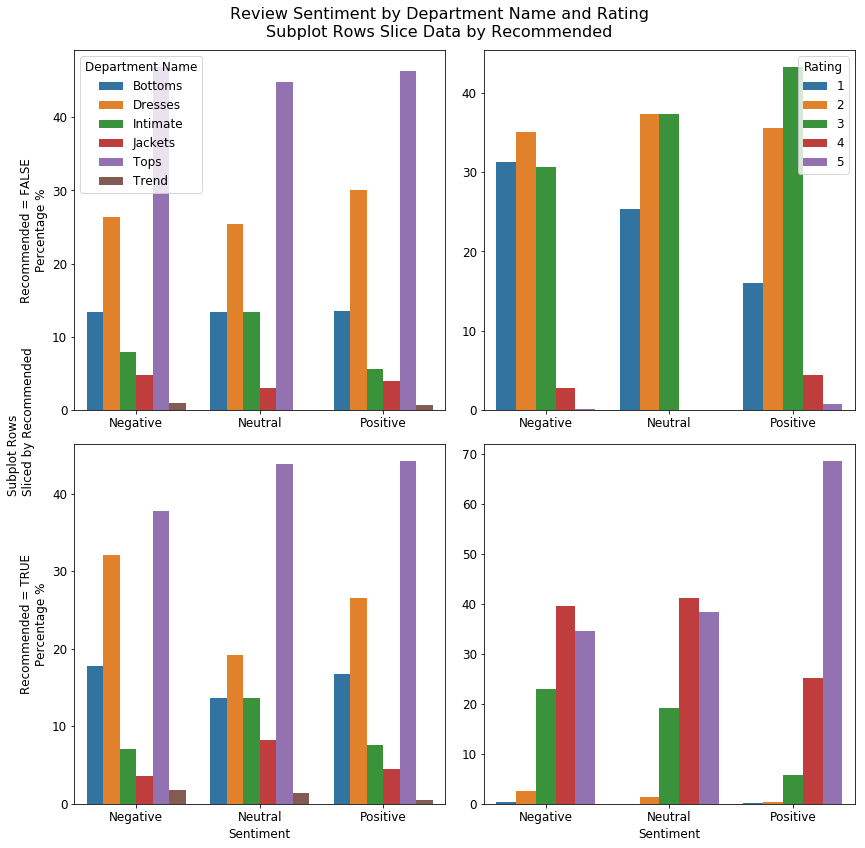

In [39]:
xvar = 'Sentiment'
huevar = 'Department Name'
rowvar = 'Recommended IND'

# Plot
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False, sharey=False)
for i,x in enumerate(set(df[rowvar][df[rowvar].notnull()])):
    percentstandardize_barplot(x=xvar, y='Percentage', hue=huevar, data=df[df[rowvar] == x],
                               ax=axes[i,0], order=['Negative','Neutral','Positive'])
    percentstandardize_barplot(x=xvar, y='Percentage', hue='Rating', data=df[df[rowvar] == x],
                               ax=axes[i,1], order=['Negative','Neutral','Positive'])

# Plot Aesthetics
axes[1,0].legend_.remove()
axes[1,1].legend_.remove()
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[0,0].set_ylabel('Recommended = FALSE\nPercentage %')
axes[1,0].set_ylabel('Recommended = TRUE\nPercentage %')
axes[1,1].set_title('')

# Common title and ylabel
f.text(0.0, 0.5, 'Subplot Rows\nSliced by Recommended', va='center', rotation='vertical', fontsize=12)
f.suptitle('Review Sentiment by Department Name and Rating\nSubplot Rows Slice Data by Recommended', fontsize=16)
f.tight_layout()
f.subplots_adjust(top=0.93)
plt.savefig('sentiment-deptname-rating-recommended.png', format='png', dpi=300)
plt.show()

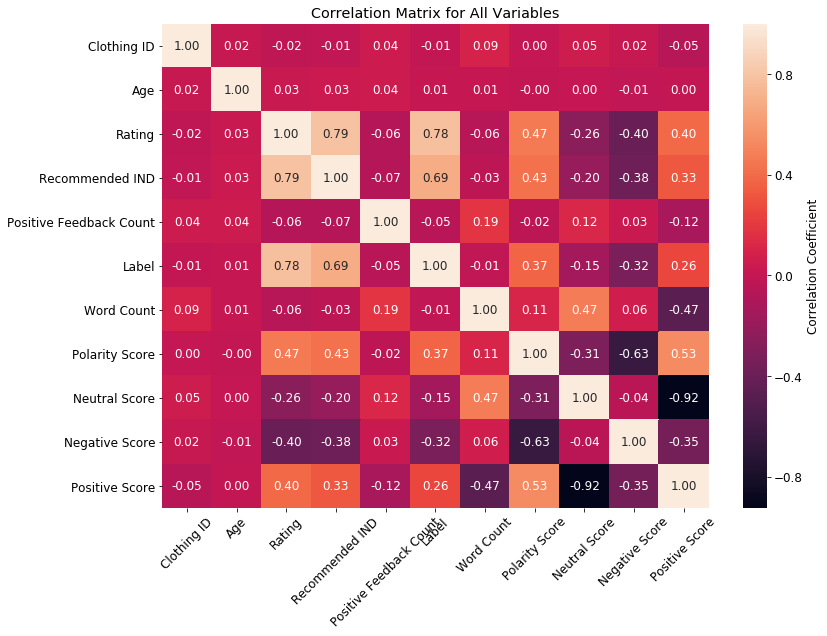

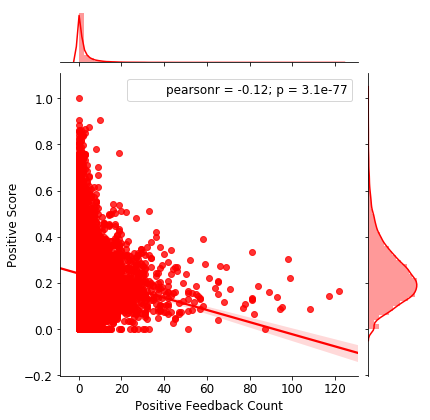

In [40]:
f, ax = plt.subplots(figsize=[12, 9])
ax = sns.heatmap(df.corr(), annot=True,
                 fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Correlation Matrix for All Variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('corr-all.png', format='png', dpi=300)
plt.show()

# Sentiment Positivity Score by Positive Feedback Count
ax = sns.jointplot(x= df['Positive Feedback Count'], y=df['Positive Score'], kind='reg', color='r')
plt.savefig('positivesentiment-positivefeedback.png', format='png', dpi=300)
plt.show()

# Word Distribution and Word Cloud

In [41]:
import matplotlib as mpl

stopwords = set(STOPWORDS)
size = (20, 10)

def cloud(text, title, stopwords=stopwords, size=size):
    mpl.rcParams['figure.figsize'] = (10.0, 10.0)
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['figure.subplot.bottom'] = .1
    
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords).generate(str(text))
    
    fig = plt.figure(figsize=size, facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=50, color='y')
    plt.tight_layout()
    plt.savefig('{}.png'.format(title), format='png', dpi=300)
    plt.show()
    
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    mpl.style.use('ggplot')
    rslt.plot.bar(rot=0)
    
def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rlst = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    return rlst

## Visualize Titles

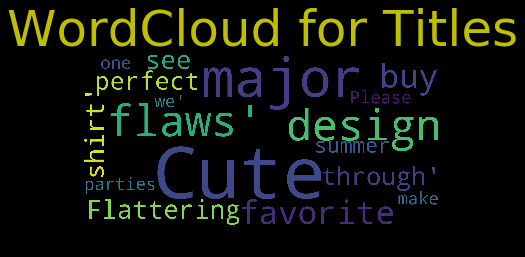

In [43]:
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df['Class Name'][df['Class Name'].notnull()].unique())]
                + ['dress', 'petite'])

# Cloud
cloud(text=df.Title[df.Title.notnull()].astype(str).values,
      title='WordCloud for Titles',
      stopwords=new_stop,
      size = (7,4))

## Visualize Reviews

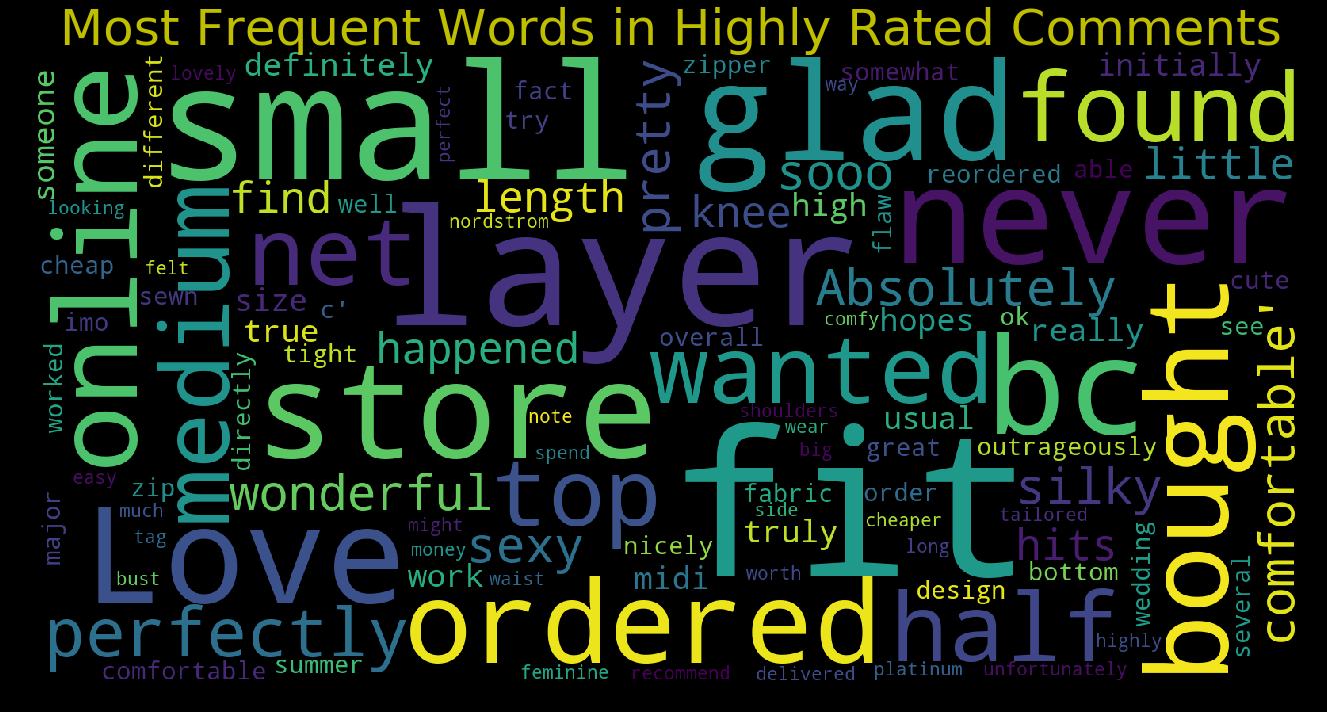

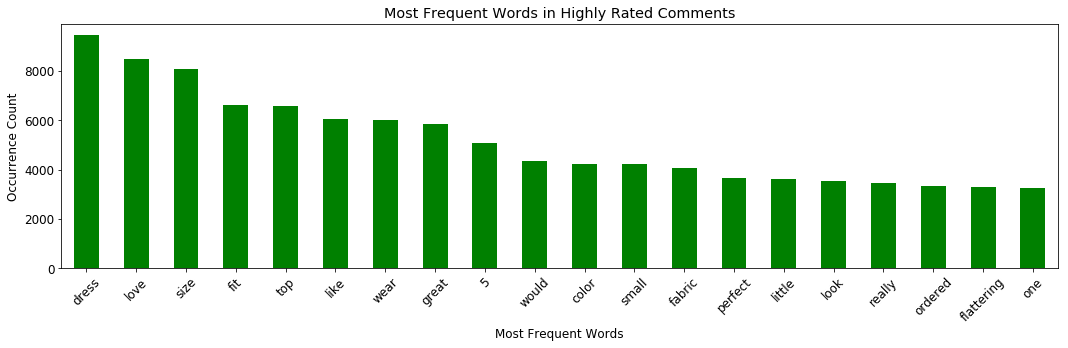

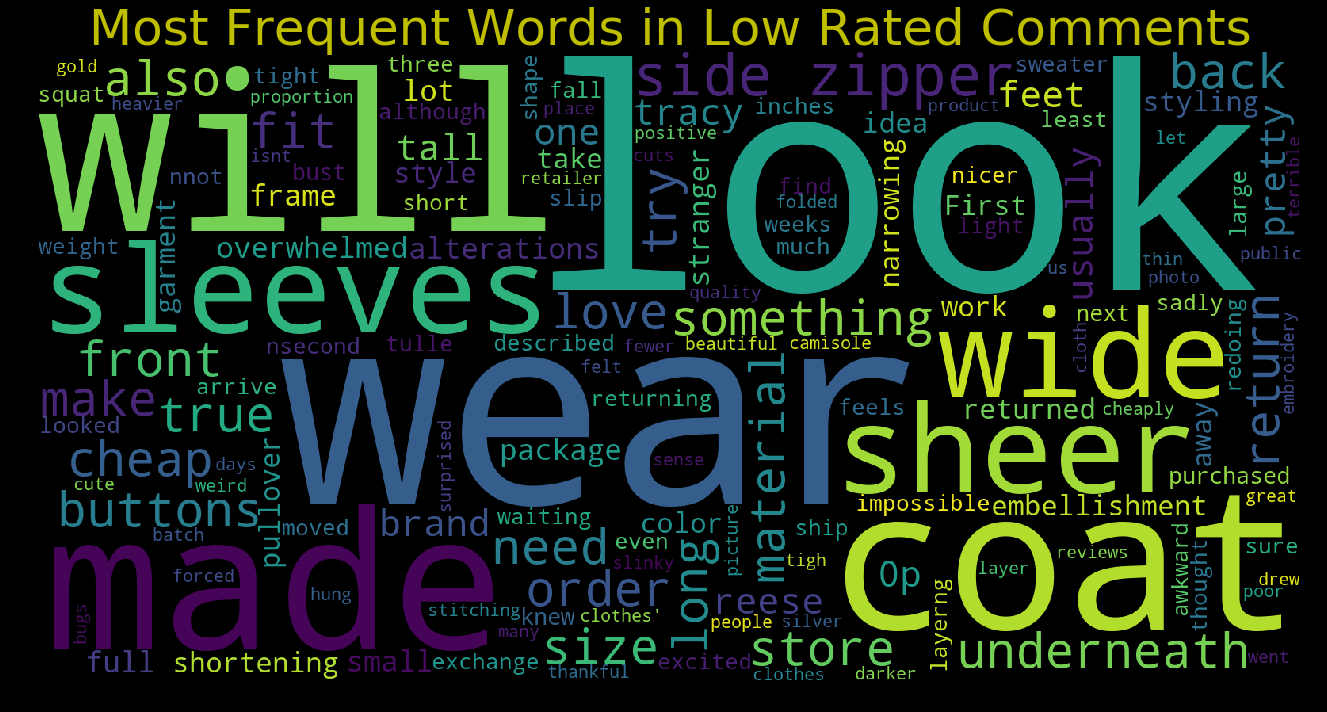

In [44]:
title ='Most Frequent Words in Highly Rated Comments'
temp = df['Review Text'][df.Rating.astype(int) >= 3]

# Modify Stopwords to Exclude Class types, suchs as 'dress'
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df['Class Name'][df['Class Name'].notnull()].unique())]
                + ['dress', 'petite'])

# Cloud
cloud(text= temp.values, title=title,stopwords= new_stop)

# Bar Chart
wordfreq(preprocessing(temp), 20).plot.bar(rot=45, legend=False, figsize=(15, 5), color='g',
                                          title=title)
plt.ylabel('Occurrence Count')
plt.xlabel('Most Frequent Words')
plt.tight_layout()
plt.savefig('most-freq-words-high-rate-comments.png', format='png', dpi=300)
plt.show()

# Low Raited
title ='Most Frequent Words in Low Rated Comments'
temp = df['Review Text'][df.Rating.astype(int) < 3]

# Modify Stopwords to Exclude Class types, suchs as 'dress'
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df['Class Name'][df['Class Name'].notnull()].unique())]
                + ['dress', 'petite', 'skirt', 'shirt'])

# Cloud
cloud(temp.values, title=title, stopwords=new_stop)

## WordClouds by Department Name

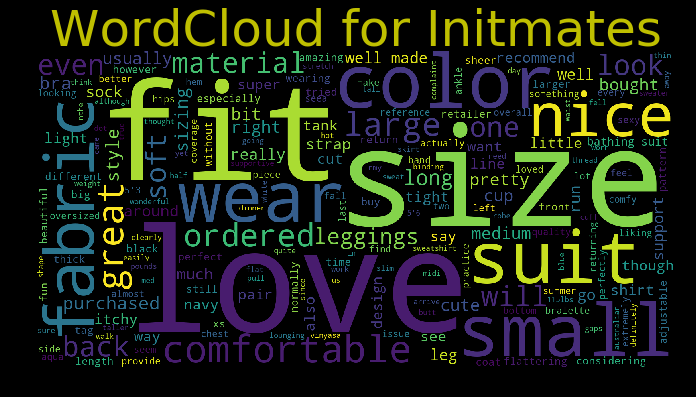

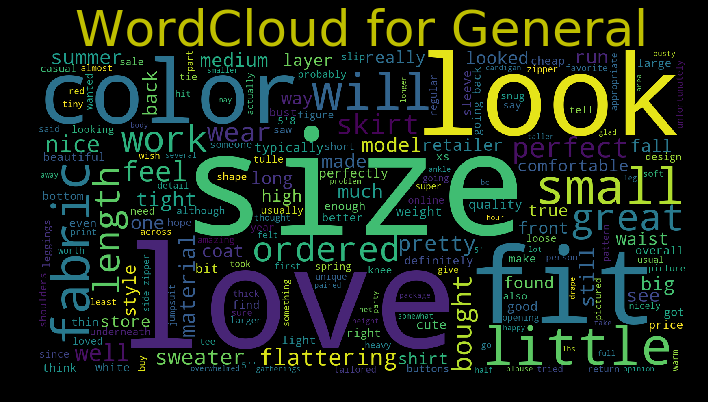

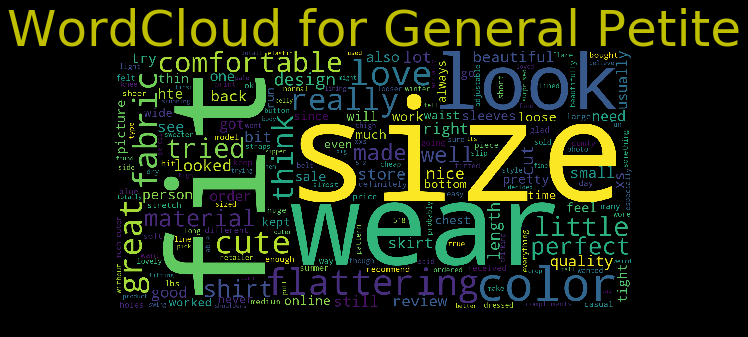

In [45]:
department_set = df['Department Name'][df['Department Name'].notnull()].unique()
division_set = df['Division Name'][df['Division Name'].notnull()].unique()
def cloud_by_category(data, category, subclass):
    """Function to create a wordcloud by class and subclass
    Category signifies the column variable
    Subclass refers to the specific value within the categorical variable"""
    new_stop = set(STOPWORDS)
    new_stop.update([x.lower() for x in list(data['Class Name'][data['Class Name'].notnull()].unique())]
                   + [x.lower() for x in list(data['Department Name'][data['Department Name'].notnull()].unique())]
                   + ['dress', 'petite', 'jacket', 'top'])

    # Cloud
    cloud(text= data['Review Text'][data[category]== subclass],
          title='WordCloud for {}'.format(subclass),
          stopwords= new_stop,
          size = (10,6))
    
# Plot
cloud_by_category(df, 'Division Name', division_set[0])
cloud_by_category(df, 'Division Name', division_set[1])
cloud_by_category(df, 'Division Name', division_set[2])

# Supervised Learning

## Recommended IND Classification

In [13]:
reviews = df['Review Text'].astype(str).str.lower()

In [14]:
type(reviews)

pandas.core.series.Series

In [15]:
features = reviews.tolist()

In [16]:
features

['absolutely wonderful - silky and sexy and comfortable',
 'love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
 'i had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
 "i love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments

In [17]:
import re
from string import punctuation

In [18]:
for index in range(len(features)):
    all_text = ''.join([character for character in features[index] if character not in punctuation])
    features[index] = re.split(r'\n|\r', all_text)
    features[index] = ' '.join([word for word in features[index]])

In [19]:
features

['absolutely wonderful  silky and sexy and comfortable',
 'love this dress  its sooo pretty  i happened to find it in a store and im glad i did bc i never would have ordered it online bc its petite  i bought a petite and am 58  i love the length on me hits just a little below the knee  would definitely be a true midi on someone who is truly petite',
 'i had such high hopes for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reordered it in petite medium which was just ok overall the top half was comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layers imo a major design flaw was the net over layer sewn directly into the zipper  it c',
 'i love love love this jumpsuit its fun flirty and fabulous every time i wear it i get nothing but great compliments',
 'this shirt is very flattering to al

In [20]:
labels = np.array(df['Recommended IND'], np.int)

In [21]:
labels.shape

(22628,)

In [22]:
labels[labels == 1].shape[0]

18527

In [23]:
labels[labels == 0].shape[0]

4101

In [24]:
from keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [25]:
labels = to_categorical(labels)

In [26]:
labels[:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [27]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [28]:
t = Tokenizer()
t.fit_on_texts(features)
vocabulary_size = len(t.word_index) + 1

In [29]:
print('Vocabulary size : {}'.format(vocabulary_size))

Vocabulary size : 19370


In [30]:
encoded_features = t.texts_to_sequences(features)

max_length = 300

padded_features = pad_sequences(encoded_features, maxlen=max_length, padding='post')

In [31]:
embeddings_index = dict()
with open('/home/darth/GitHub Projects/senti-internship-notes/abienagarap/word-vectors/glove.840B.300d.txt') as file:
    data = file.readlines()
    
# store <key, value> pair of FastText vectors
for line in data[1:]:
    word, vec = line.split(' ', 1)
    embeddings_index[word] = np.array([float(index) for index in vec.split()], dtype='float32')
print('Loaded {} word vectors.'.format(len(embeddings_index)))


embedding_matrix = np.zeros((vocabulary_size, max_length))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 2196015 word vectors.


In [32]:
words = []
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        words.append(word)

In [33]:
print('{} words covered.'.format(len(words)))

13911 words covered.


In [34]:
percentage = (len(words) / vocabulary_size) * 100.00
print('{}% of {} words were covered'.format(percentage, vocabulary_size))

71.81724315952503% of 19370 words were covered


In [35]:
def train_test_split(features, labels, **kwargs):
    
    # concatenate the features and labels array
    dataset = np.c_[features, labels]

    # shuffle the dataset
    np.random.shuffle(dataset)

    # split the dataset into features, labels
    features, labels = dataset[:, 0:max_length], dataset[:, max_length:]

    # get the split size for training dataset
    split_index = int(kwargs['train_size'] * len(features))

    # split the dataset into training/validation dataset
    train_features, validation_features = features[:split_index], features[split_index:]
    train_labels, validation_labels = labels[:split_index], labels[split_index:]

    # get the split size for validation dataset
    split_index = int(kwargs['validation_size'] * len(validation_features))

    # split the validation dataset into validation/testing dataset
    validation_features, test_features = validation_features[:split_index], validation_features[split_index:]
    validation_labels, test_labels = validation_labels[:split_index], validation_labels[split_index:]

    # return the partitioned dataset
    return [train_features, train_labels], [validation_features, validation_labels], [test_features, test_labels]

In [36]:
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.60, validation_size=0.50)

In [37]:
print('Dataset size : {}'.format(padded_features.shape[0]))
print('Train dataset size : {}'.format(train_dataset[0].shape[0]))
print('Validation dataset size : {}'.format(validation_dataset[0].shape[0]))
print('Test dataset size : {}'.format(test_dataset[0].shape[0]))

Dataset size : 22628
Train dataset size : 13576
Validation dataset size : 4526
Test dataset size : 4526


In [38]:
from keras import callbacks
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold

In [39]:
model = Sequential()
e = Embedding(vocabulary_size, max_length,
              weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.50))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_dataset[0], train_dataset[1], epochs=32, batch_size=256, verbose=1,
          validation_data=(validation_dataset[0], validation_dataset[1]))

score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

print('loss : {}, acc : {}'.format(score[0], score[1]))

Train on 13576 samples, validate on 4526 samples
Epoch 1/32
13576/13576 [==============================] - 73s 5ms/step - loss: 0.4502 - acc: 0.8169 - val_loss: 0.4518 - val_acc: 0.8217
Epoch 2/32
13576/13576 [==============================] - 71s 5ms/step - loss: 0.3600 - acc: 0.8367 - val_loss: 0.3523 - val_acc: 0.8453
Epoch 3/32
13576/13576 [==============================] - 72s 5ms/step - loss: 0.3420 - acc: 0.8553 - val_loss: 0.3068 - val_acc: 0.8631
Epoch 4/32
13576/13576 [==============================] - 72s 5ms/step - loss: 0.3067 - acc: 0.8654 - val_loss: 0.2977 - val_acc: 0.8589
Epoch 5/32
13576/13576 [==============================] - 72s 5ms/step - loss: 0.2848 - acc: 0.8764 - val_loss: 0.3526 - val_acc: 0.8647
Epoch 6/32
13576/13576 [==============================] - 72s 5ms/step - loss: 0.3129 - acc: 0.8656 - val_loss: 0.4690 - val_acc: 0.7520
Epoch 7/32
13576/13576 [==============================] - 72s 5ms/step - loss: 0.3273 - acc: 0.8553 - val_loss: 0.2902 - val_acc:

In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_dataset[0])
test_predictions = np.argmax(test_predictions, axis=1)

class_names = ['(0) Not recommended class', '(1) Recommended class']
report = classification_report(np.argmax(test_dataset[1], axis=1), test_predictions, target_names=class_names)

In [41]:
print(report)

                           precision    recall  f1-score   support

(0) Not recommended class       0.70      0.65      0.68       847
    (1) Recommended class       0.92      0.94      0.93      3679

              avg / total       0.88      0.88      0.88      4526



In [42]:
conf_matrix = confusion_matrix(np.argmax(test_dataset[1], axis=1), test_predictions)
print(conf_matrix)

[[ 552  295]
 [ 236 3443]]


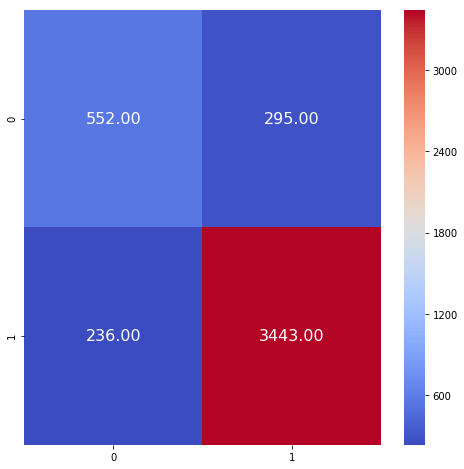

In [43]:
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')
plt.savefig('conf_matrix_recommendation.png', format='png', dpi=300)

In [44]:
from sklearn.metrics import roc_auc_score

roc = roc_auc_score(y_score=test_predictions, y_true=np.argmax(test_dataset[1], 1))
print(roc)

0.7937820290855948


In [45]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(np.argmax(test_dataset[1], 1), test_predictions)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.7937820290855948


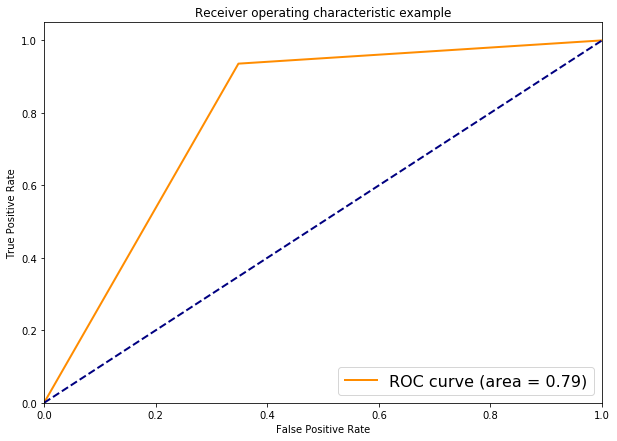

In [46]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, lw=2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right', fontsize=16)
plt.savefig('roc.png', format='png', dpi=300)
plt.show()

## Sentiment Classification

In [47]:
labels = np.array(df['Sentiment'])

In [48]:
labels

array(['Positive', 'Positive', 'Positive', ..., 'Positive', 'Positive',
       'Positive'], dtype=object)

In [49]:
labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels],
                  np.int)

In [50]:
labels

array([2, 2, 2, ..., 2, 2, 2])

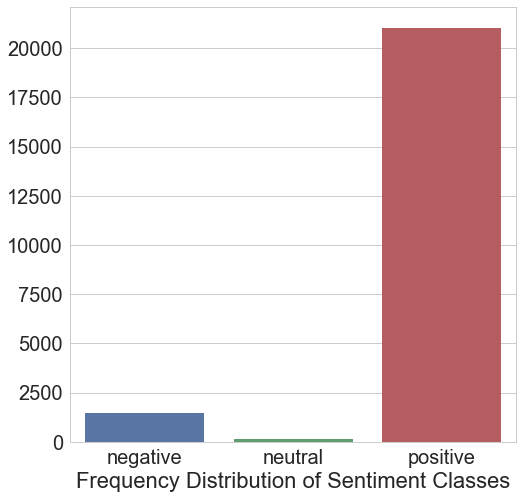

In [51]:
positive_class = int(labels[labels == 2].shape[0])
neutral_class = int(labels[labels == 1].shape[0])
negative_class = int(labels[labels == 0].shape[0])

df = pd.DataFrame.from_dict({'positive': [positive_class], 'negative': [negative_class], 'neutral': [neutral_class]})

plt.figure(figsize=(8, 8))
sns.set(font_scale=2)
sns.set_style('whitegrid')
ax = sns.barplot(data=df)
ax = ax.set_xlabel('Frequency Distribution of Sentiment Classes')

In [52]:
labels = to_categorical(labels)

In [53]:
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.60, validation_size=0.50)

In [54]:
model = Sequential()
e = Embedding(vocabulary_size, max_length,
              weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(256), merge_mode='sum'))
model.add(Dropout(0.50))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_dataset[0], train_dataset[1], epochs=32, batch_size=256, verbose=1,
          validation_data=(validation_dataset[0], validation_dataset[1]))

score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

print('loss : {}, acc : {}'.format(score[0], score[1]))

Train on 13576 samples, validate on 4526 samples
Epoch 1/32
13576/13576 [==============================] - 84s 6ms/step - loss: 0.3044 - acc: 0.9168 - val_loss: 0.2650 - val_acc: 0.9286
Epoch 2/32
13576/13576 [==============================] - 83s 6ms/step - loss: 0.2603 - acc: 0.9304 - val_loss: 0.2686 - val_acc: 0.9286
Epoch 3/32
13576/13576 [==============================] - 83s 6ms/step - loss: 0.2370 - acc: 0.9307 - val_loss: 0.2266 - val_acc: 0.9289
Epoch 4/32
13576/13576 [==============================] - 84s 6ms/step - loss: 0.2188 - acc: 0.9314 - val_loss: 0.2298 - val_acc: 0.9273
Epoch 5/32
13576/13576 [==============================] - 84s 6ms/step - loss: 0.2132 - acc: 0.9314 - val_loss: 0.2076 - val_acc: 0.9295
Epoch 6/32
13576/13576 [==============================] - 83s 6ms/step - loss: 0.1972 - acc: 0.9338 - val_loss: 0.2132 - val_acc: 0.9291
Epoch 7/32
13576/13576 [==============================] - 83s 6ms/step - loss: 0.1843 - acc: 0.9339 - val_loss: 0.2138 - val_acc:

In [55]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_dataset[0])
test_predictions = np.argmax(test_predictions, axis=1)

class_names = ['(0) Negative class', '(1) Neutral class', '(2) Positive class']
report = classification_report(np.argmax(test_dataset[1], axis=1), test_predictions, target_names=class_names)

In [56]:
print(report)

                    precision    recall  f1-score   support

(0) Negative class       0.47      0.50      0.49       289
 (1) Neutral class       0.31      0.18      0.23        22
(2) Positive class       0.96      0.96      0.96      4215

       avg / total       0.93      0.93      0.93      4526



In [57]:
conf_matrix = confusion_matrix(np.argmax(test_dataset[1], axis=1), test_predictions)
print(conf_matrix)

[[ 145    2  142]
 [   6    4   12]
 [ 155    7 4053]]


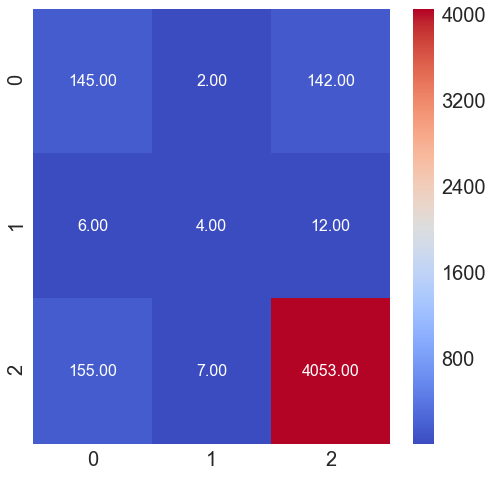

In [58]:
plt.figure(figsize=(8, 8))
plt.savefig('conf_matrix_sentiment.png', format='png', dpi=300)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')